In [1]:
%matplotlib inline
import inspect, os, sys, copy, pytz, re, glob
import simplejson as json
import pandas as pd
from dateutil import parser
import datetime
import matplotlib.pyplot as plt   # Matplotlib for plotting
import matplotlib.dates as md
import numpy as np
import seaborn as sns
import pybloom
utc=pytz.UTC

ENV = "production"
os.environ['CS_ENV'] = ENV
BASE_DIR = "/home/reddit/CivilServant"
sys.path.append(BASE_DIR)

with open(os.path.join(BASE_DIR, "config") + "/{env}.json".format(env=ENV), "r") as config:
  DBCONFIG = json.loads(config.read())

### LOAD SQLALCHEMY
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy import text

db_engine = create_engine("mysql://{user}:{password}@{host}/{database}".format(
    host = DBCONFIG['host'],
    user = DBCONFIG['user'],
    password = DBCONFIG['password'],
    database = DBCONFIG['database']))
DBSession = sessionmaker(bind=db_engine)

### LOAD PRAW
import reddit.connection
conn = reddit.connection.Connect(base_dir=BASE_DIR)

### FILTER OUT DEPRECATION WARNINGS ASSOCIATED WITH DECORATORS
# https://github.com/ipython/ipython/issues/9242
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message='.*use @default decorator instead.*')

### Load PRAW session

In [2]:
r = conn.connect(controller="ModLog")

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/v1/me.json
POST: https://api.reddit.com/api/v1/access_token/
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/v1/me.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/v1/me.json


### Load Official Historical r/science posts

In [4]:
#glob.glob("/mnt/corsair/reddit_archive/official-bigquery-data/science_posts*")

In [5]:
post_ids = pybloom.BloomFilter(capacity=10000000, error_rate = .000000001)
science_posts = []
files = ['/mnt/corsair/reddit_archive/official-bigquery-data/science_posts_to_12_2015.json',
 '/mnt/corsair/reddit_archive/official-bigquery-data/science_posts_12_2015.json',
 '/mnt/corsair/reddit_archive/official-bigquery-data/science_posts_01_2016.json',
 '/mnt/corsair/reddit_archive/official-bigquery-data/science_posts_02_2016.json',
 '/mnt/corsair/reddit_archive/official-bigquery-data/science_posts_03_2016.json',
 '/mnt/corsair/reddit_archive/official-bigquery-data/science_posts_04_2016.json',
 '/mnt/corsair/reddit_archive/official-bigquery-data/science_posts_05_2016.json']
counter = 0
for file in files:
    print
    sys.stdout.write(file)
    sys.stdout.flush()
    with open(file, "r") as lines:
        for line in lines:
            post = json.loads(line)
            if post['id'] not in post_ids:
                post['created'] = utc.localize(datetime.datetime.utcfromtimestamp(int(post['created_utc'])))
                science_posts.append(post)
                post_ids.add(post['id'])
            counter += 1
            if(counter % 1000) == 0:
                sys.stdout.write(".")
                sys.stdout.flush()

/mnt/corsair/reddit_archive/official-bigquery-data/science_posts_to_12_2015.json..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................../mnt/corsair/reddit_archive/official-bigquery-data/science_posts_12_2015.json...../mnt/corsair/reddit_archive/official-bigquery-data/science_posts_01_2016.json...../mnt/corsair/reddit_archive/official-bigquery-data/science_posts_02_2016.json...../mnt/corsair/reddit_archive/official-bigquery-data/science_posts_03_2016.json...../mnt/corsair/reddit_archive/

### Load Baumgartner Posts from the last month (includes some gaps)

In [6]:
head = parser.parse('2016-06-01 00:00:00 UTC')
tail = parser.parse('2016-06-30 23:59:59 UTC')
with open("/mnt/corsair/reddit_archive/baumgartner-bigquery-data/reddit_science_posts_2016.json", "r") as lines:
    for line in lines:
        post = json.loads(line)
        post['created'] = parser.parse(post['created_utc'])
        if(post['created'] >= head and
           post['created'] <= tail and post['id'] not in post_ids):
            science_posts.append(post)
            post_ids.add(post['id'])


### Add days since epoch to the list of posts

In [7]:
for post in science_posts:
    post['day_num'] = (post['created'] - utc.localize(datetime.datetime(1970,1,1))).days

### Create a Pandas Dataframe from data

In [8]:
posts_df = pd.DataFrame(science_posts)

### Plot posts per day in the entire history of the subreddit

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  app.launch_new_instance()


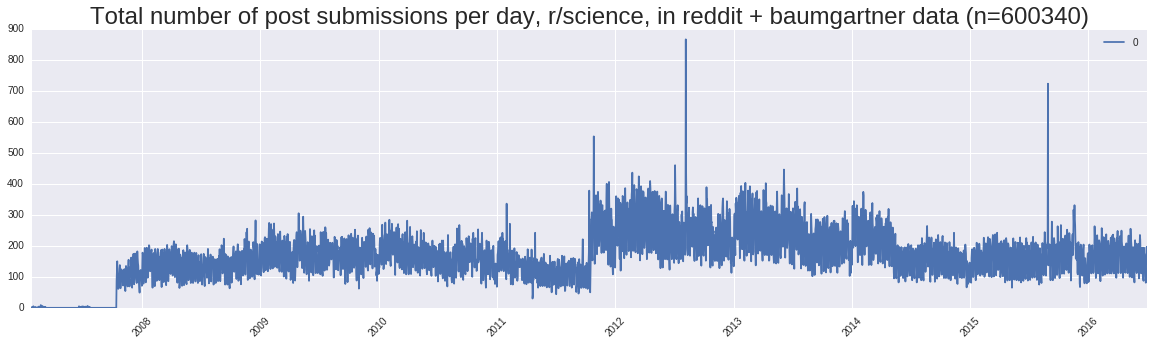

In [9]:
x = pd.DataFrame(posts_df.created.values, index=posts_df.created.values.astype('datetime64'))
fig, ax = plt.subplots(figsize=(20,5))
x.resample("D", how="count").plot(rot=45, ax=ax)
plt.title("Total number of post submissions per day, r/science, in reddit + baumgartner data (n={0})".format(posts_df.created.count()), fontsize="24")

In [11]:
posts_df[posts_df.created>parser.parse('2016-04-01 00:00:00 UTC')].created.count()

15371

### Load Moderator Actions Going Back to April 4, 2016

In [12]:
recent_mod_actions = []
for row in db_engine.execute(text('select action_data from mod_actions WHERE subreddit_id="mouw" ORDER BY created_utc;')):
    mod_action = json.loads(row['action_data'])
    mod_action['created'] = utc.localize(datetime.datetime.utcfromtimestamp(mod_action['created_utc']))
    recent_mod_actions.append(mod_action)

### Tag posts as visible based on moderation log

In [13]:
posts_2016 = {}
for post in posts_df[posts_df.created>=recent_mod_actions[0]['created']].to_dict("records"):
    post['visible'] = True
    posts_2016[post['id']] = post
recent_post_count = len(posts_2016.values())
print("Recent Post Count: {0}".format(recent_post_count))

Recent Post Count: 14777


In [14]:
missing_mod_actions = []
matched_mod_actions = 0
for action in recent_mod_actions:
    if action['action'] == "removelink":
        key = action['target_fullname'].replace("t3_","")
        if key in posts_2016.keys():
            posts_2016[key]['visible'] = False
            matched_mod_actions += 1
        else:
            missing_mod_actions.append(key)
    elif action['action'] == 'approvelink':
        key = action['target_fullname'].replace("t3_","")
        if key in posts_2016.keys():
            posts_2016[key]['visible'] = True
            matched_mod_actions += 1
        else:
            missing_mod_actions.append(key)
print("Missing Mod Actions: {0}".format(len(missing_mod_actions)))
print("Missing Mod Action Posts: {0}".format(len(set(missing_mod_actions))))
print("Matched Mod Actions: {0}".format(matched_mod_actions))

Missing Mod Actions: 783
Missing Mod Action Posts: 543
Matched Mod Actions: 15085


### Fetch missing posts from reddit

In [15]:
extra_posts = []
for submission in r.get_submissions(["t3_" + x for x in set(missing_mod_actions)]):
    extra_posts.append(submission.json_dict)

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/by_id/t3_4qqypx,t3_4qs2g7,t3_4rgmi1,t3_4dd5jm,t3_4rcurl,t3_4qri1y,t3_4ra3a3,t3_4ra7xq,t3_4qxr76,t3_4r44u3,t3_4r6fcm,t3_4qwz9j,t3_4qx001,t3_4rhwgy,t3_4rim19,t3_4qv14j,t3_4r139n,t3_4r14cu,t3_4qq2dn,t3_4rebr0,t3_4qrik2,t3_4qpbpo,t3_4r62wb,t3_4ra7i4,t3_4rhnyj,t3_4r76ne,t3_4rdyxx,t3_4r3hsm,t3_jd0dd,t3_4rh0n8,t3_4r2qm0,t3_4rbthi,t3_4qwxab,t3_4qqajf,t3_4r117q,t3_4qz6dh,t3_4rcedl,t3_4rgtvc,t3_4qyvel,t3_4dbg7j,t3_phvr1,t3_43g15s,t3_4qpnoc,t3_4r0pep,t3_4qsuo8,t3_4rg2ht,t3_4qt0n2,t3_4qt4xn,t3_4rc83z,t3_4rfc4z,t3_4qrl0y,t3_476d3i,t3_4rdm60,t3_4r25as,t3_4r0tuh,t3_4r6ymb,t3_4rhue4,t3_4r3559,t3_4rb43r,t3_4rg0e0,t3_4risd5,t3_4qus3z,t3_4rce0m,t3_4r3b02,t3_4qurxw,t3_to7tq,t3_4dbvmr,t3_4qufc0,t3_4riucr,t3_4risb1,t3_4qvquw,t3_4retby,t3_4rbkmu,t3_4qronl,t3_4ri50j,t3_4qv0lb,t3_4rin88,t3_4qvx5i,t3_4rds38,t3_4rd6qz,t3_4qrrgq,t3_4rcwei,t3_4qs842,t3_4qw1r3,t3_4qwyll,t3_4qtoty,t3_4rbrcw,t3_4r3u15,t3_4rbisr,t3_4r

In [16]:
### AND NO NEED TO GO BACK THROUGH THE MODERATION ACTION LIST
### FOR THESE, SINCE THEY WILL HAVE THE banned_by PROPERTY

before_time_window = 0
within_time_window = 0

for post in extra_posts:
    post['created'] = utc.localize(datetime.datetime.utcfromtimestamp(int(post['created_utc'])))
    if post['created'] >= recent_mod_actions[0]['created']:
        if(post['banned_by'] is not None):
            post['visible'] = False
        else:
            post['visible'] = True
        posts_2016[post['id']] = post
        within_time_window += 1
    else:
        before_time_window += 1
    
print("Extra posts within time window: {0}".format(within_time_window))
print("Extra posts before time window: {0}".format(before_time_window))
    
for post in posts_2016.values():
    post['day_num'] = (post['created'] - utc.localize(datetime.datetime(1970,1,1))).days

Extra posts within time window: 489
Extra posts before time window: 54


### Create Dataframe to Chart Submitted versus Permitted Posts Per Day

In [17]:
recent_posts = pd.DataFrame(list(posts_2016.values()))
print("Posts before update from modlog: {0}".format(recent_post_count))
print("Posts after update from modlog: {0}".format(recent_posts.created.count()))

Posts before update from modlog: 14777
Posts after update from modlog: 15266


### Plot Posts Per Day in Recent History of Subreddit

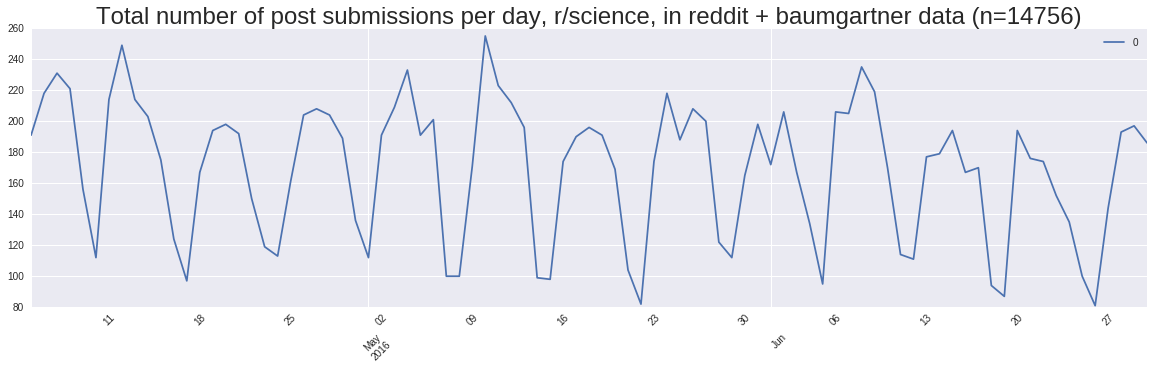

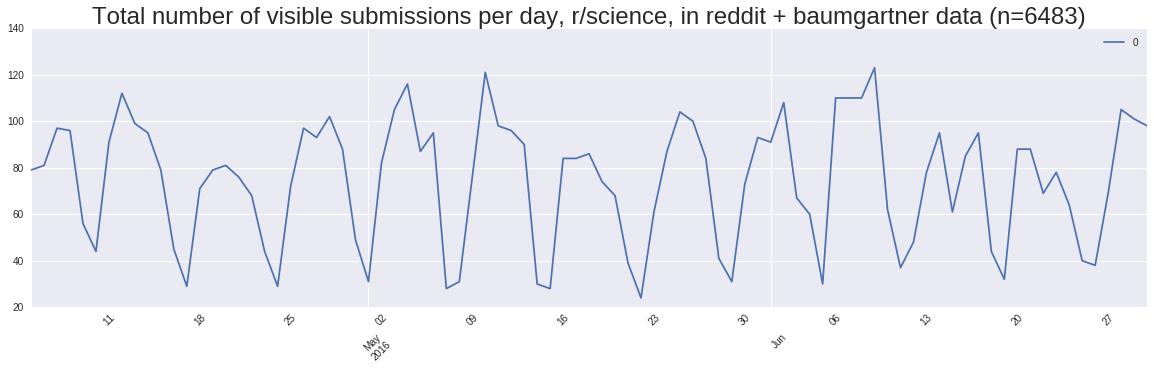

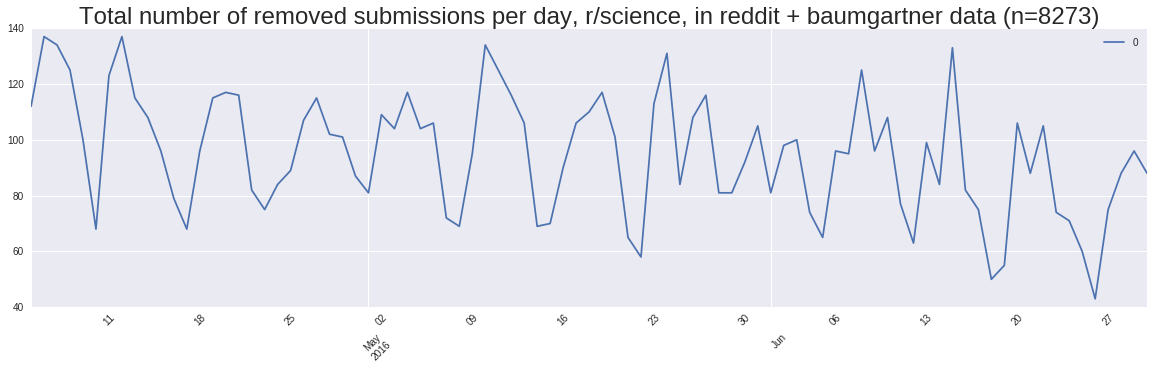

In [19]:
### TOTAL SUBMISSIONS
df = recent_posts[((recent_posts.created <= parser.parse("2016-07-01 00:00:00 UTC")) &
                   (recent_posts.created >= parser.parse("2016-04-05 00:00:00 UTC")))]
x = pd.DataFrame(df.created.values, index=df.created.values.astype('datetime64'))
fig, ax = plt.subplots(figsize=(20,5))
x.resample("D").count().plot(rot=45, ax=ax)
plt.title("Total number of post submissions per day, r/science, in reddit + baumgartner data (n={0})".format(df.created.count()), fontsize="24")
plt.show()

total_counts = x.resample("D").count().to_dict("records")

### NOW ACCEPTED SUBMISSIONS
df = recent_posts[((recent_posts.visible == True) & 
                   (recent_posts.created <= parser.parse("2016-07-01 00:00:00 UTC")) &
                   (recent_posts.created >= parser.parse("2016-04-05 00:00:00 UTC")))]
x = pd.DataFrame(df.created.values, index=df.created.values.astype('datetime64'))
fig, ax = plt.subplots(figsize=(20,5))
x.resample("D").count().plot(rot=45, ax=ax)
plt.title("Total number of visible submissions per day, r/science, in reddit + baumgartner data (n={0})".format(df.created.count()), fontsize="24")
plt.show()

retained_counts = x.resample("D").count().to_dict("records")

### NOW REMOVED SUBMISSIONS
df = recent_posts[((recent_posts.visible == False) & 
                   (recent_posts.created <= parser.parse("2016-07-01 00:00:00 UTC")) & 
                   (recent_posts.created >= parser.parse("2016-04-05 00:00:00 UTC")))]
x = pd.DataFrame(df.created.values, index=df.created.values.astype('datetime64'))
fig, ax = plt.subplots(figsize=(20,5))
x.resample("D").count().plot(rot=45, ax=ax)
plt.title("Total number of removed submissions per day, r/science, in reddit + baumgartner data (n={0})".format(df.created.count()), fontsize="24")
plt.show()

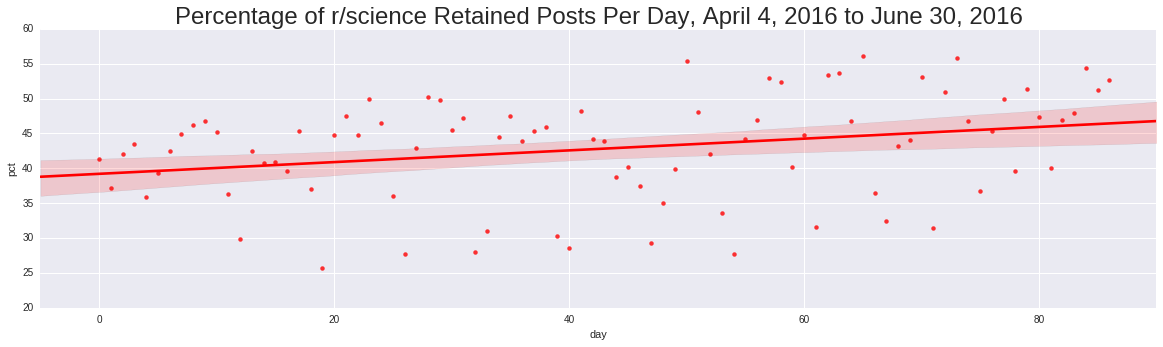

In [20]:
retained_proportion_per_day = []
for i in range(0,len(total_counts)):
    retained_proportion_per_day.append({
            "day":i,
            "pct": (float(retained_counts[i][0]) / float(total_counts[i][0]) * 100.)
            })
recent_prop_df = pd.DataFrame(retained_proportion_per_day)

fig, ax = plt.subplots(figsize=(20,5))
ax.set_xlim(left=-5, right=90)
sns.regplot(x="day", y="pct", data=recent_prop_df,ax=ax, color="R")
plt.title("Percentage of r/science Retained Posts Per Day, April 4, 2016 to June 30, 2016", fontsize="24")

# Construct Dependent Variables: 
* newcomer comments on posts that are allowed to remain
* the number of newcomer comments on posts that are allowed to remain
* the number of removed newcomer comments on posts that are allowed to remain

### Load last six months of comments from official reddit dataset

In [96]:
comment_head = parser.parse("2015-12-01 00:00:00 UTC")
all_comments = {}
comment_ids = pybloom.BloomFilter(capacity=10000000, error_rate = .000000001)

for filename in [#'/mnt/corsair/reddit_archive/official-bigquery-data/science_comments_12_2015.json',
                 '/mnt/corsair/reddit_archive/official-bigquery-data/science_comments_01_2016.json',
                 '/mnt/corsair/reddit_archive/official-bigquery-data/science_comments_02_2016.json',
                 '/mnt/corsair/reddit_archive/official-bigquery-data/science_comments_03_2016.json',
                 '/mnt/corsair/reddit_archive/official-bigquery-data/science_comments_04_2016.json',
                 '/mnt/corsair/reddit_archive/official-bigquery-data/science_comments_05_2016.json']:
    sys.stdout.write(".")
    sys.stdout.flush()
    with open(filename, "r") as lines:
        for line in lines:
            comment = json.loads(line)
            if(comment['id'] not in comment_ids):
                comment['created'] = utc.localize(datetime.datetime.utcfromtimestamp(float(comment['created_utc'])))
                comment['visible'] = True
                if(comment['body'] == "[removed]"):
                    comment['visible'] = False
                comment['body.length'] = len(comment['body'])
                comment['body'] = None
                comment['body_html'] = None
                all_comments[comment['id']] = comment
                comment_ids.add(comment['id'])

.....

### Load Baumgartner Comments from the last month
Unlike the post data, I checked this and found no gaps, at least going from the moderation log


In [97]:
tail = parser.parse('2016-05-30 23:59:59 UTC')
count = 0
with open("/mnt/corsair/reddit_archive/baumgartner-bigquery-data/reddit_science_comments_2016.json", "r") as comment_file:
    for line in comment_file:
        comment = json.loads(line)
        if(comment['id'] not in comment_ids):
            comment['created'] = parser.parse(comment['created_utc'])
            if(comment['created'] <= tail):
                comment['body.length'] = len(comment['body'])
                comment['body'] = None
                comment['body_html'] = None
                all_comments[comment['id']] = comment
                comment_ids.add(comment['id'])
        count += 1
        if(count % 50000 == 0):
            sys.stdout.write(".")
            sys.stdout.flush()

........

### Add in comments missed by Baumgartner but picked up in the moderation log
This code found only one missing mod comment from the Baumgartner data (probably just a timing issue). So I'm going to avoid adding in the moderation log data.

In [32]:
# mod_comments = []
# new_mod_comments = set()
# for action in recent_mod_actions:
#     if action['action'] == "removecomment" or action['action'] == "approvecomment":
#         comment = {}
#         comment['id'] = mod_action['target_fullname'].replace("t1_", "")

#         #TODO: if it's a remove
#         #TODO: if it's an approve

# print("New mod comments: {0}".format(len(new_mod_comments)))

New mod comments: 1


### Construct a time sorted list of comments

In [110]:
import heapq

class CommentHeapObj(object):
    def __init__(self, comment):
        self.index = int(comment['created_utc'])
        self.val = comment
    def __lt__(self, other):
        return self.index < other.index

def heapsort(comments):
    h = []
    for comment in comments:
        heapq.heappush(h, CommentHeapObj(comment))
    return [heapq.heappop(h).val for i in range(len(h))]

all_comments = heapsort(all_comments.values())

### Add Author Comment Number to All Comments

In [141]:
from collections import defaultdict, Counter

author_comment_num = defaultdict(int)

for comment in all_comments:
    comment['author.prev.comments'] = author_comment_num[comment['author']]    
    author_comment_num[comment['author']] += 1


# Create Dataframes for Analysis

### Create a Dataset of Comments from April 4 2016 going forward
Tagged comments with information about the post they were attached to, including:
* were they top-level comments or replies?
* what flair did the post have
* what time was the post made
* was the post removed

In [128]:
comment_head = recent_mod_actions[0]['created']
recent_comments = [x for x in all_comments if x['created']>comment_head]
print("Total number of comments: {0}".format(len(all_comments)))
print("Recent comments: {0}".format(len(recent_comments)))

Total number of comments: 435434
Recent comments: 168985


#### Fetch any missing posts

In [137]:
recent_comment_posts = list(set([x['link_id'] for x in recent_comments]))
unfetched_posts = []
for post in recent_comment_posts:
    if post.replace("t3_", "") not in posts_2016.keys():
        unfetched_posts.append(post)

new_posts_fetched = 0
for submission in r.get_submissions(unfetched_posts):
    post = submission.json_dict
    post['created'] = utc.localize(datetime.datetime.utcfromtimestamp(int(post['created_utc'])))
    post['day_num'] = (post['created'] - utc.localize(datetime.datetime(1970,1,1))).days
    ## we do actually want to get all posts in this set so we can add their covariates
    if(post['banned_by'] is not None):
        post['visible'] = False
    else:
        post['visible'] = True
    posts_2016[post['id']] = post
    new_posts_fetched += 1
print("Fetched {0} new posts".format(new_posts_fetched))

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/by_id/t3_41inhb,t3_4d7nqz,t3_4cr9uq,t3_4dbjdi,t3_3z0dr7,t3_41zr2t,t3_4d8fy8,t3_3w02oj,t3_47e5gv,t3_42ssv2,t3_4bko8g,t3_3vnr69,t3_4dc51z,t3_4bgumr,t3_46eglm,t3_4d9sf8,t3_41dni8,t3_4dcf9m,t3_49i88b,t3_49pd00,t3_4cpl6d,t3_4dbgzh,t3_4brtod,t3_4came7,t3_3qqsku,t3_4cvzhx,t3_3qyhtd,t3_4dct5d,t3_4anasi,t3_49dpda,t3_48kh83,t3_45w7hl,t3_4ckc8g,t3_4dd96d,t3_3qpaw9,t3_43g15s,t3_48c840,t3_4cqow3,t3_3wsqn4,t3_4d3dcw,t3_4c1ad3,t3_4cwuuk,t3_4306oe,t3_4dab9j,t3_4btbyb,t3_4483en,t3_4d9k6j,t3_4c167b,t3_3vauxn,t3_42msxr,t3_4bw1tv,t3_48wxsx,t3_458dmz,t3_3tkvfz,t3_4bduqg,t3_48njxg,t3_4dazbd,t3_3zoj7z,t3_4acov4,t3_466hy2,t3_3up38w,t3_493axr,t3_4d68q6,t3_3zpkkl,t3_4dbhiq,t3_4cx1xh,t3_4dc4zf,t3_4cblw6,t3_49t5gf,t3_3z3gtn,t3_3xu1te,t3_4bgzth,t3_4cmnsy,t3_4cyzi1,t3_45cei3,t3_4dco4y,t3_46gshl,t3_4cr5my,t3_42ytv5,t3_49fiw7,t3_49t3h8,t3_4c9q4m,t3_48x2oo,t3_4dbimc,t3_489xei,t3_3ouhvw,t3_49u1iw,t3_3yv7ww,t3_4bbc65,t3

Fetched 159 new posts


#### Now attach post-level covariates to comments

In [240]:
def is_ama(flair):
    if(flair is None or (isinstance(flair, str))!=True):
        return None
    return "ama" in flair

def is_badpost(flair):
    if(flair is None or (isinstance(flair, str))!=True):
        return None
    return "badpost" in flair

def strip_ama(flair):
    if(flair is None or (isinstance(flair, str))!=True):
        return None
#    try:
    flairs = [x for x in flair.split() if("ama" not in x and "badpost" not in x)]
#    except:
#        import pdb;pdb.set_trace()
    if(len(flairs)==0):
        return None
    return flairs[0] ## Confirmed that this is always only one flair

for comment in recent_comments:
    post = posts_2016[comment['link_id'].replace("t3_", "")]
    
    comment['post.ama'] = is_ama(post['link_flair_css_class'])
    comment['post.badpost'] = is_badpost(post['link_flair_css_class'])
    comment['post.flair'] = strip_ama(post['link_flair_css_class'])
    comment['post.created'] = post['created']
    comment['post.author'] = post['author']
    comment['post.visible'] = post['visible']
    comment['toplevel'] = comment['link_id'] == comment['parent_id']
    comment['post.domain'] = post['domain']
    comment['post.day.num']  = post['day_num']
    comment['day.num'] = (comment['created'] - utc.localize(datetime.datetime(1970,1,1))).days
    comment['weekday'] = comment['created'].weekday()
    comment['weekend'] = (comment['weekday'] >=6)

In [241]:
import time
recent_comment_df = pd.DataFrame(recent_comments)
earliest_datetime = recent_comments[0]['created'].strftime("%Y.%m.%d_%H.%M.%S")
latest_datetime = recent_comments[-1]['created'].strftime("%Y.%m.%d_%H.%M.%S")
recent_comments_filename = "r_science_comments_" + earliest_datetime + "-" + latest_datetime + ".csv"
recent_comment_df.to_csv(os.path.join("outputs",recent_comments_filename))

#### Now Generate and output a post-level dataset

In [242]:
# from comment_head onward
#post_comments = {}
for post in posts_2016.values():
#    post['newcomer.commenters'] = set()
    post['newcomer.comments'] = 0
    post['newcomer.comments.removed'] = 0
    post['commenters'] = set()
    post['num.comments']  = 0
    post['num.comments.removed'] = 0
    post['post.ama'] = is_ama(post['link_flair_css_class'])
    post['post.badpost'] = is_badpost(post['link_flair_css_class'])
    post['post.flair'] = strip_ama(post['link_flair_css_class'])
    post['weekday'] = post['created'].weekday()
    post['weekend'] = (post['weekday'] >=6)
    
for comment in recent_comments:
    post = posts_2016[comment['link_id'].replace("t3_", "")]
    if comment['author.prev.comments'] == 0:
#        post['newcomer.commenters'].append(comment['author'])
        post['newcomer.comments'] += 1
        post['commenters'].add(post['author'])
        post['num.comments'] += 1
        if(comment['visible']!=True):
            post['newcomer.comments.removed'] += 1
            post['num.comments.removed'] +=1

In [243]:
recent_post_df = pd.DataFrame(list(posts_2016.values()))
recent_posts_filename = "r_science_posts_" + earliest_datetime + "-" + latest_datetime + ".csv"
recent_post_df.to_csv(os.path.join("outputs", recent_posts_filename))

# Questions for the Experiment

### When should the treatment switch be thrown every day?

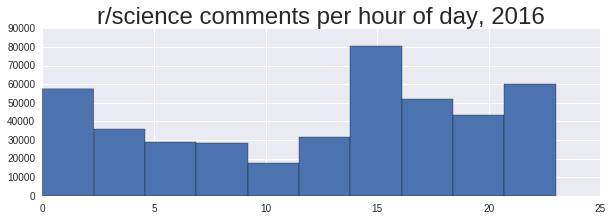

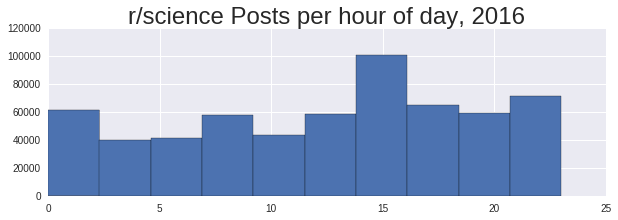

In [204]:
plt.figure(figsize=(10, 3)) 
plt.hist([x['created'].hour for x in list(all_comments)])
plt.title("r/science comments per hour of day, 2016", fontsize="24")
plt.show()

plt.figure(figsize=(10, 3)) 
plt.hist([x['created'].hour for x in science_posts])
plt.title("r/science Posts per hour of day, 2016", fontsize="24")
plt.show()


2